This workbook begins using the environment we have setup on Azure Machine Learning to iterate through several multilayer perceptrons.

In [1]:
import os
import shutil
import pickle

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array, load_img)
from tensorflow.keras import callbacks, models, layers, losses

from azureml.core import Workspace, Dataset, ScriptRunConfig
from azureml.tensorboard import Tensorboard

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import log_runs, visualize_log, plot_accuracy

# Setup

Load in the resources created in the first notebook, and setup for these expirments

In [4]:
# Load the stored workspace
ws = Workspace.from_config()

In [5]:
# Get the registered dataset from azure
dataset = Dataset.get_by_name(ws, name='waste_images')

In [6]:
from azureml.core.environment import Environment
#from azureml.core.conda_dependencies import CondaDependencies

# get the registered env
env = Environment.get(ws, 'waste-env-gpu')

In [7]:
# get our compoute cluster
# for cnn we will use a gpu cluster
compute_name = "gpu-cluster2-NC6"
compute_target = ws.compute_targets[compute_name]

## Write control script

The control script will be uploaded to aml instances in azure.  Images are cached in Azure, so parameterizing the script results in faster run times than submitting new scrips for each run.  It also allows for faster iteration

In [8]:
%%writefile train.py

import argparse
import os
import shutil
import numpy as np
import pickle

from azureml.core import Run
from azureml.core import Workspace, Dataset

from tensorflow.keras.preprocessing.image import (ImageDataGenerator, array_to_img, 
                                       img_to_array, load_img)
from tensorflow.keras import callbacks
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses

from utils import count_files

# set seed for reproducibility
np.random.seed(867)

# output will be logged, separate output from previous log entries.
print('-'*100)

# parse the parameters passed to the this script
parser = argparse.ArgumentParser()
parser.add_argument('--data_path', type=str, 
                    dest='data_path', 
                    default='data', 
                    help='data folder mounting point')


parser.add_argument('--conv_nodes', 
                    type=str, 
                    dest='conv_nodes', 
                    default='32', 
                    help='number of nodes in each layer (comma separated)')
parser.add_argument('--conv_kernel_sizes', 
                    type=str, 
                    dest='conv_kernel_sizes', 
                    default='32', 
                    help='kernel_size for each convolution layer (comma separated)')
parser.add_argument('--conv_activations', 
                    type=str, 
                    dest='conv_activations', 
                    default='relu', 
                    help='activation function to use on hidden layers (comma separated)')
parser.add_argument('--pool_sizes', 
                    type=str, 
                    dest='pool_sizes', 
                    default='(2,2)', 
                    help='pool size for max pooling layer (comma separated)')

    
parser.add_argument('--dense_nodes', 
                    type=str, 
                    dest='dense_nodes', 
                    default='32', 
                    help='number of nodes in each layer (comma separated)')
parser.add_argument('--dense_activations', 
                    type=str, 
                    dest='dense_activations', 
                    default='relu', 
                    help='activation function to use on hidden layers (comma separated)')

parser.add_argument('--optimizer', 
                    type=str, 
                    dest='optimizer', 
                    default='sgd', 
                    help='optimizer to use')
parser.add_argument('--epochs', 
                    type=int, 
                    dest='epochs', 
                    default=5, 
                    help='number of epochs to try.')
args = parser.parse_args()

# split list args into lists
conv_nodes = [int(x) for x in args.conv_nodes.split(',')]
conv_kernel_sizes = args.conv_kernel_sizes[1:-1].split('],[')
conv_kernel_sizes = [(int(x.split(',')[0]),int(x.split(',')[0])) for x in conv_kernel_sizes]
conv_activations = args.conv_activations.split(',')
pool_sizes = args.pool_sizes[1:-1].split('],[')
pool_sizes = [(int(x.split(',')[0]),int(x.split(',')[0])) for x in pool_sizes]

dense_nodes = args.dense_nodes.split(',')
dense_activations = args.dense_activations.split(',')

# get azure run context
run = Run.get_context()

# print to log for debuggig if necessary
print('Data folder:',args.data_path)

print('Convolution Nodes:', conv_nodes)
for node in conv_nodes:
    print(type(node))

print('Convolution kernel_sizes:', conv_kernel_sizes)
for node in conv_kernel_sizes:
    print(type(node))

print('ConvolutionActivations:', conv_activations)
for node in conv_activations:
    print(type(node))

print('Pool Sizes', pool_sizes)
for node in pool_sizes:
    print(type(node))
    
print('Dense Nodes:', dense_nodes)
print('Dense Activations:', dense_activations)

# set data paths
train_folder = os.path.join(args.data_path, 'train')
val_folder = os.path.join(args.data_path, 'validation')
test_folder = os.path.join(args.data_path, 'test')

# count the number of files in each split
num_train = count_files(train_folder)
num_val = count_files(val_folder)
num_test = count_files(test_folder)

# print number of files in each split to log
print('Num Train Files:', num_train)
print('Num Val Files:', num_val)
print('Num Test Files:', num_test)


# Create generators for importing the images
print('Creating train ImageDataGenerator')
train_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(train_folder,
                                             #target_size = (244, 244),
                                             batch_size = 32)
print('Creating validation ImageDataGenerator')
val_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(val_folder,
                                             #target_size = (244, 244),
                                             batch_size = num_val)
print('Creating test ImageDataGenerator')
test_generator = ImageDataGenerator(rescale=1/255)\
                        .flow_from_directory(test_folder,
                                             #target_size = (244, 244),
                                             batch_size = num_test)

# model callbacks
my_callbacks = [
    callbacks.EarlyStopping(patience=3),
    callbacks.ModelCheckpoint(filepath=f'outputs/{run.id}.h5',
                              save_best_only=True),
    callbacks.TensorBoard(log_dir=f'logs/{run.properties["name"]}/',
                          histogram_freq=1,
                          profile_batch=0)
]

# Build the model
model = models.Sequential()

for node, kernel_size, activation, pool_size in zip(conv_nodes, 
                                         conv_kernel_sizes, 
                                         conv_activations,
                                         pool_sizes):
    print(f'Creating Conv2D layer with {node} nodes,',
          f'kernel_size={kernel_size} and activation={activation}')
    model.add(layers.Conv2D(node, kernel_size, activation=activation))
    print(f'Creating MaxPooling2d layer with pool_size={pool_size}')
    model.add(layers.MaxPooling2D(pool_size))

model.add(layers.Flatten())

# create hidden layers based on parameters
for node, activation in zip(dense_nodes, dense_activations):
    print(f'Creating Dense layer with {node} nodes and activation={activation}')
    model.add(layers.Dense(node, activation=activation))

# final layer for classification
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=args.optimizer,
              loss='categorical_crossentropy',
              metrics=['acc'])

# fit model and store history
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=args.epochs,
                    callbacks=my_callbacks)

print('Saving model history...')
with open(f'outputs/{run.id}.history', 'wb') as f:
    pickle.dump(history.history, f)

# print model summary to log
model.summary()

print('evaluating model on test set...')
model_val = model.evaluate(test_generator)

print('Test Loss:', model_val[0])
print('Test Accuracy:', model_val[1])

run.log('test_loss', np.float(model_val[0]))
run.log('test_accuracy', np.float(model_val[1]))

print('Done!')
print('-'*100)

Overwriting train.py


In [9]:
if not os.path.exists('cnn_train_script'):
    os.mkdir('cnn_train_script')

# move the file to the upload dir
shutil.copy('train.py', 'cnn_train_script/')
shutil.copy('utils.py', 'cnn_train_script/')


'cnn_train_script/utils.py'

## Iterate models

Now that we have a control script we can start submitting runs of various models to azure compute.  They will run asynchronously in parallel which will make this process comparatively fast.

In [22]:
# set the expiriment
experiment_name = 'cnn'
from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

In [147]:
# create var to stor run objects
runs = []

### Model 1 - Baseline
- hidden layer 1: 32 nodes, sigmoid activation function
- hidden layer 2: 16 nodes, sigmoid activation function
- optimizer: sgd

In [148]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--conv_nodes', '32,64',
        '--conv_kernel_sizes', '[2,2],[2,2]',
        '--conv_activations', 'relu,relu',
        '--pool_sizes', '[2,2],[2,2]', 
        '--dense_nodes', '64',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory='cnn_train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [149]:
runs.append(exp.submit(config=src))

# Add name and tags for tracking
runs[-1].add_properties({'name': 'conv32-64dense64'})

runs[-1].tag('class', 'cnn')
runs[-1].tag('activation', 'relu')
runs[-1].tag('optimizer', 'sgd')
runs[-1].tag('hidden layers', '3')
runs[-1].tag('convolution layers', '2')
runs[-1].tag('dense layers', '1')

### Start Tensorboard to monitor the runs

In [76]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [77]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

### Evaluate runs

In [13]:
from azureml.core import Run
run = Run.get(ws, 'cnn_1615742146_d03a61e5')

In [16]:
runs = [run]

In [18]:
log = log_runs(runs, 'cnn')
log

{'test_loss': 1.5096192359924316, 'test_accuracy': 0.5483871102333069}

,name,type,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
cnn_1615742146_d03a61e5,conv32-64dense64,cnn,1.509619,0.548387,"[1.7262964248657227, 1.66776704788208, 1.62684...","[0.21610915660858154, 0.2865316867828369, 0.34...","[1.6832735538482666, 1.5840280055999756, 1.523...","[0.23664122819900513, 0.40458014607429504, 0.4..."


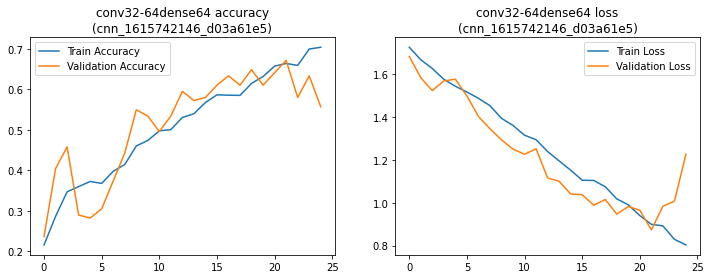

In [202]:
visualize_log(log.loc[[r.id for r in runs]])

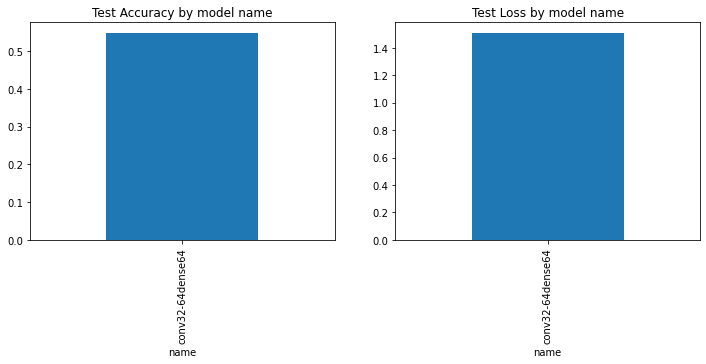

In [203]:
plot_accuracy(log.loc[[r.id for r in runs]])

Talk about runs here.

# Test 1
In this test I will experiment with different sizes for the convolution layers.

In [19]:
runs2 = [runs[0]]

### Model 2 
- Convolution Layer 1 nodes: 64
- Convolution Layer 2 nodes: 128
- Dense layer activation: sigmoid
- optimizer: 

In [23]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--conv_nodes', '64,128',
        '--conv_kernel_sizes', '[2,2],[2,2]',
        '--conv_activations', 'relu,relu',
        '--pool_sizes', '[2,2],[2,2]', 
        '--dense_nodes', '64',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory='cnn_train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [24]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'conv64-128dense64'})

runs2[-1].tag('class', 'cnn')
runs2[-1].tag('activation', 'relu')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('hidden layers', '3')
runs2[-1].tag('convolution layers', '2')
runs2[-1].tag('dense layers', '1')

### Model 3
- Convolution Layer 1 nodes: 128
- Convolution Layer 2 nodes: 256
- optimizer: sgd

In [25]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--conv_nodes', '128,256',
        '--conv_kernel_sizes', '[2,2],[2,2]',
        '--conv_activations', 'relu,relu',
        '--pool_sizes', '[2,2],[2,2]', 
        '--dense_nodes', '64',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory='cnn_train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [26]:
runs2.append(exp.submit(config=src))

# Add name and tags for tracking
runs2[-1].add_properties({'name': 'conv128-256dense256'})

runs2[-1].tag('class', 'cnn')
runs2[-1].tag('activation', 'relu')
runs2[-1].tag('optimizer', 'sgd')
runs2[-1].tag('hidden layers', '3')
runs2[-1].tag('convolution layers', '2')
runs2[-1].tag('dense layers', '1')

# Start Tensorboard to monitor runs

In [136]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs2)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [121]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

### Evaluate runs

In [166]:
runs2

[Run(Experiment: cnn,
 Id: cnn_1615742146_d03a61e5,
 Type: azureml.scriptrun,
 Status: Preparing),
 Run(Experiment: cnn,
 Id: cnn_1615742956_531610f7,
 Type: azureml.scriptrun,
 Status: Preparing),
 Run(Experiment: cnn,
 Id: cnn_1615742964_383b97fa,
 Type: azureml.scriptrun,
 Status: Preparing),
 Run(Experiment: cnn,
 Id: cnn_1615742969_4a392157,
 Type: azureml.scriptrun,
 Status: Preparing),
 Run(Experiment: cnn,
 Id: cnn_1615742975_e36e70be,
 Type: azureml.scriptrun,
 Status: Preparing),
 Run(Experiment: cnn,
 Id: cnn_1615742981_ae184178,
 Type: azureml.scriptrun,
 Status: Preparing)]

In [82]:
log = log_runs(runs2, 'cnn')
log

{'test_loss': 1.2955955266952515, 'test_accuracy': 0.5483871102333069}

,name,type,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
id,,,,,,,,
mlp_1615656464_eb63f1c0,sigmoid-sgd,mlp,1.463566,0.467742,"[1.7974865436553955, 1.7372865676879883, 1.713...","[0.1729753464460373, 0.2315140813589096, 0.277...","[1.7528793811798096, 1.7180869579315186, 1.692...","[0.17557251453399658, 0.3358778655529022, 0.30..."
mlp_1615656470_ffdc4734,relu-sgd,mlp,1.716608,0.233871,"[2.2597947120666504, 1.7758759260177612, 1.767...","[0.21478873491287231, 0.23503521084785461, 0.2...","[1.7806367874145508, 1.7706297636032104, 1.762...","[0.23664122819900513, 0.23664122819900513, 0.2..."
mlp_1615656474_a157ccc3,sigmoid-adam,mlp,1.716935,0.233871,"[1.770506501197815, 1.726367712020874, 1.72556...","[0.20246478915214539, 0.23503521084785461, 0.2...","[1.7273155450820923, 1.7236706018447876, 1.722...","[0.23664122819900513, 0.23664122819900513, 0.2..."
mlp_1615656477_520a50bc,relu-adam,mlp,1.753966,0.225806,"[12.43702507019043, 2.7881507873535156, 1.8240...","[0.1672535240650177, 0.16109155118465424, 0.20...","[2.6074233055114746, 1.9728984832763672, 1.739...","[0.16030533611774445, 0.18320611119270325, 0.1..."
mlp_1615662400_c559f912,64-32,mlp,1.432114,0.475806,"[1.7310034036636353, 1.6935681104660034, 1.662...","[0.2262323945760727, 0.28213027119636536, 0.31...","[1.7007421255111694, 1.6550861597061157, 1.627...","[0.30534350872039795, 0.3129771053791046, 0.40..."
mlp_1615662404_abb8f887,128-64,mlp,1.423573,0.475806,"[1.7328224182128906, 1.6764565706253052, 1.638...","[0.24295774102210999, 0.28213027119636536, 0.3...","[1.6752843856811523, 1.6190940141677856, 1.572...","[0.28244274854660034, 0.30534350872039795, 0.3..."
mlp_1615662408_e19be324,256-128,mlp,1.483568,0.483871,"[1.7225266695022583, 1.6626874208450317, 1.611...","[0.24119718372821808, 0.2922535240650177, 0.35...","[1.6789530515670776, 1.5968527793884277, 1.516...","[0.23664122819900513, 0.2748091518878937, 0.48..."
mlp_1615662412_ddb748ec,512-256,mlp,1.516856,0.435484,"[1.7175407409667969, 1.6343629360198975, 1.586...","[0.24779929220676422, 0.30765846371650696, 0.3...","[1.6526559591293335, 1.5529580116271973, 1.492...","[0.3435114622116089, 0.37404578924179077, 0.35..."
mlp_1615664407_c3d5232d,128-64-32,mlp,1.468782,0.467742,"[1.8021928071975708, 1.7308865785598755, 1.719...","[0.23019365966320038, 0.23503521084785461, 0.2...","[1.7397912740707397, 1.718546986579895, 1.7101...","[0.23664122819900513, 0.23664122819900513, 0.2..."


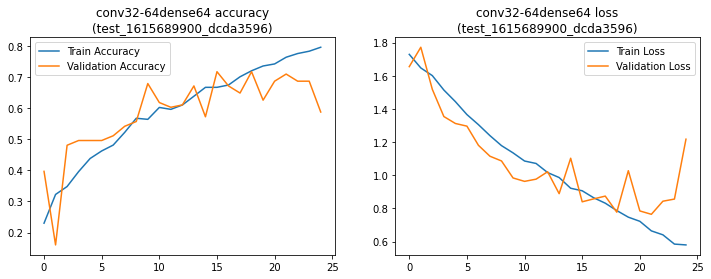

In [83]:
visualize_log(log.loc[[r.id for r in runs2]])

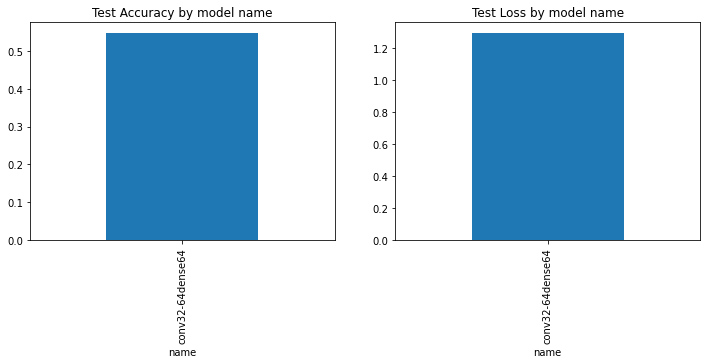

In [84]:
plot_accuracy(log.loc[[r.id for r in runs2]])

The best performing was 23/64.  Try adding another convolution layer.

In [ ]:
run3 = run2?

# Test 2
Add more convolutional layers to our best performing model so far

### Model 4
- Convolution Layer 1 nodes: 32
- Convolution Layer 2 nodes: 64
- Convolution Layer 2 nodes: 128
- optimizer: sgd

In [27]:
# Add existing models for comparison
runs3 = [runs[0]]

In [30]:
args = ['--data_path', dataset.as_named_input('input').as_mount(),
        '--conv_nodes', '32,64,128',
        '--conv_kernel_sizes', '[2,2],[2,2],[2,2]',
        '--conv_activations', 'relu,relu,relu',
        '--pool_sizes', '[2,2],[2,2],[2,2]', 
        '--dense_nodes', '64',
        '--dense_activations', 'relu',
        '--optimizer', 'sgd',
        '--epochs', '50']

src = ScriptRunConfig(source_directory='cnn_train_script/',
                      script='train.py', 
                      arguments=args,
                      compute_target=compute_target,
                      environment=env)

In [31]:
runs3.append(exp.submit(config=src))

# Add name and tags for tracking
runs3[-1].add_properties({'name': 'conv32-64-128-dense64'})

runs3[-1].tag('class', 'cnn')
runs3[-1].tag('activation', 'relu')
runs3[-1].tag('optimizer', 'sgd')
runs3[-1].tag('hidden layers', '4')
runs3[-1].tag('convolution layers', '3')
runs3[-1].tag('dense layers', '1')

# Start Tensorboard to monitor runs

In [136]:
# Start Tensor board to monitor the run
tb = Tensorboard(runs3)
tb.start()

http://localhost:6006/


'http://localhost:6006/'

In [121]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
tb.stop()

### Evaluate runs

In [32]:
runs3

[Run(Experiment: cnn,
 Id: cnn_1615742146_d03a61e5,
 Type: azureml.scriptrun,
 Status: Completed),
 Run(Experiment: cnn,
 Id: cnn_1615761762_0bcb4c58,
 Type: azureml.scriptrun,
 Status: Preparing)]

In [34]:
log = log_runs(runs3, 'cnn')
log

{'test_loss': 1.5096192359924316, 'test_accuracy': 0.5483871102333069}

{'test_loss': 1.2297978401184082, 'test_accuracy': 0.5887096524238586}

,name,type,test_loss,test_accuracy,train_loss,train_accuracy,val_loss,val_accuracy
cnn_1615742146_d03a61e5,conv32-64dense64,cnn,1.509619,0.548387,"[1.7262964248657227, 1.66776704788208, 1.62684...","[0.21610915660858154, 0.2865316867828369, 0.34...","[1.6832735538482666, 1.5840280055999756, 1.523...","[0.23664122819900513, 0.40458014607429504, 0.4..."
cnn_1615761762_0bcb4c58,conv32-64-128-dense64,cnn,1.229798,0.588710,"[1.703869342803955, 1.6235040426254272, 1.5749...","[0.23943662643432617, 0.33362674713134766, 0.3...","[1.6368883848190308, 1.6203343868255615, 1.451...","[0.32824426889419556, 0.2671755850315094, 0.39..."


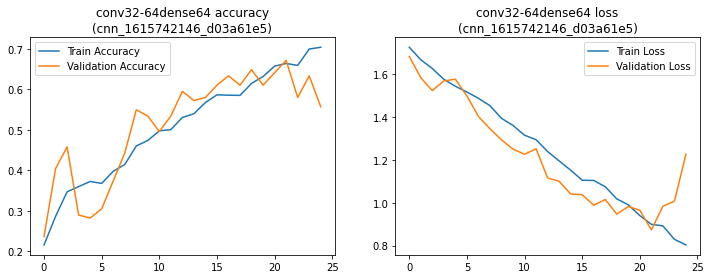

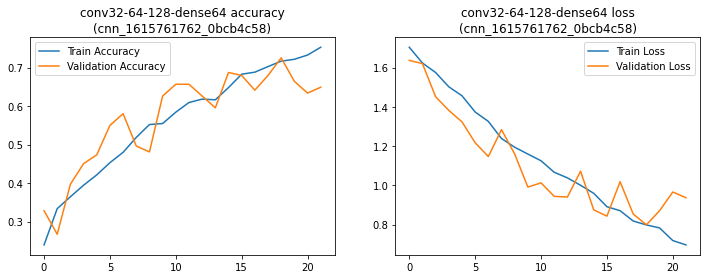

In [35]:
visualize_log(log.loc[[r.id for r in runs3]])

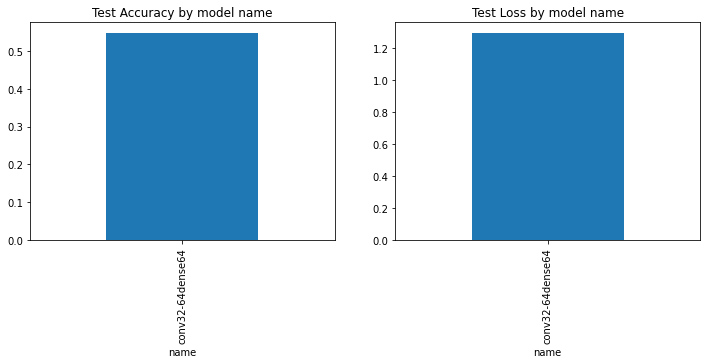

In [84]:
plot_accuracy(log.loc[[r.id for r in runs2]])

Talk about runs here.